<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/2_first_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler


In [15]:
data = pd.read_csv("dca_for_classifier.csv")

In [16]:
# ביטוי לבדיקה
keyword = "העותק כפוף לשינויי עריכה וניסוח"

# בדיקה אילו שורות מכילות את הביטוי
rows_with_keyword = data["גוף המסמך"].str.contains(keyword, na=False)

# סינון שורות שלא מכילות את הביטוי
filtered_data = data[rows_with_keyword]

# הדפסת השורות שלא מכילות את הביטוי
rows_without_keyword = data[~rows_with_keyword]
print("שורות שלא מכילות את הביטוי:\n")
print(rows_without_keyword["גוף המסמך"].to_string(index=False))

# הדפסת מספר השורות שנמחקו
num_removed = len(rows_without_keyword)
print(f"\nמספר השורות שנמחקו: {num_removed}")

# שמירת הנתונים המסוננים לקובץ חדש
filtered_data.to_csv("filtered_data.csv", index=False, encoding='utf-8')
print("\nהנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'")

data = filtered_data

שורות שלא מכילות את הביטוי:

['פסק-דין בתיק רע"פ 7861/03 בבית המשפט העליון ר...
['פסק-דין בתיק רע"פ 2038/04 בבית המשפט העליון ר...
['פסק-דין בתיק רע"פ 5978/04 בבית המשפט העליון ר...

מספר השורות שנמחקו: 3

הנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'


In [17]:
data

,גוף המסמך,מספר תיק,Outcome of case,binary_outcome
1,"['פסק-דין בתיק רע""פ 8337/04 בבית המשפט העליון ...",8337/04,G R,1.0
2,"['החלטה בתיק רע""פ 7896/04 בבית המשפט העליון רע...",7896/04,G A,1.0
5,"['החלטה בתיק רע""פ 2985/04 בבית המשפט העליון בי...",2985/04,G A,1.0
6,"['החלטה בתיק רע""פ 110/04 בבית המשפט העליון רע""...",110/04,G A,1.0
7,"['פסק דין בתיק רע""פ 2929/04 בבית המשפט העליון ...",2929/04,G R substential matter that was resolved with ...,1.0
...,...,...,...,...
726,"['החלטה בתיק רע""פ 3076/07 בבית המשפט העליון רע...",3076/07,D,0.0
727,"['החלטה בתיק רע""פ 6415/07 בבית המשפט העליון רע...",6415/07,D A,0.0
728,"['החלטה בתיק רע""פ 825/07 בבית המשפט העליון רע""...",825/07,D A,0.0
729,"['החלטה בתיק רע""פ 4180/07 בבית המשפט העליון רע...",4180/07,D A,0.0


binary_outcome
0.0    680
1.0     43
Name: count, dtype: int64


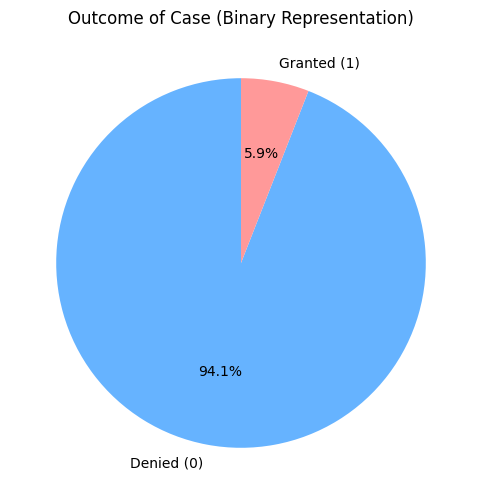

In [18]:
binary_counts = data['binary_outcome'].value_counts()
print(binary_counts)
labels = ['Denied (0)','Granted (1)']

plt.figure(figsize=(6, 6))
plt.pie(binary_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Outcome of Case (Binary Representation)')

plt.show()

In [21]:
# הגדרת פונקציה לעיצוב טקסט
def format_text(text, line_length=80):
    """
    פורמט טקסט כך שיהיה נוח לקריאה עם שורות שאורכן מוגבל.
    """
    import textwrap
    return "\n".join(textwrap.wrap(text, width=line_length))


In [30]:

tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

pytorch_model.bin:  36%|###5      | 178M/498M [00:00<?, ?B/s]

In [31]:
# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

In [32]:

# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data = data.dropna(subset=["גוף המסמך", "binary_outcome"])



In [ ]:
# עדכון עמודת המטרה ואימבדינג לאחר הסרת הערכים החסרים
y = data["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])



# Training

In [26]:

classifier = LogisticRegression(random_state=42, max_iter=1000)

# הגדרת Stratified K-Fold עם 5 פולדים כדי לשמר את יחס הכיתות
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# הגדרת מדדי הביצועים
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

In [ ]:


cv_results = cross_validate(classifier, embeddings, y, cv=cv, scoring=scoring)

print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())


### Loss function - class weight tunning

In [ ]:
# הגדרת מסווג לוגיסטי עם משקולות כיתות
classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 5})

cv_results = cross_validate(classifier, embeddings, y, cv=cv, scoring=scoring)

print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())


## UNDERSAMPLING


In [ ]:
# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)

# ביצוע undersampling
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# הגדרת מסווג וביצוע Cross Validation על הנתונים המדוללים
cv_results_resampled = cross_validate(classifier, X_resampled, y_resampled, cv=cv, scoring=scoring)

print("Cross-Validation Accuracy (after undersampling):", cv_results_resampled['test_accuracy'])
print("Mean Accuracy (after undersampling):", cv_results_resampled['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1 (after undersampling):", cv_results_resampled['test_precision'])
print("Mean Precision for Class 1 (after undersampling):", cv_results_resampled['test_precision'].mean())
print("Cross-Validation Recall for Class 1 (after undersampling):", cv_results_resampled['test_recall'])
print("Mean Recall for Class 1 (after undersampling):", cv_results_resampled['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1 (after undersampling):", cv_results_resampled['test_f1'])
print("Mean F1 Score for Class 1 (after undersampling):", cv_results_resampled['test_f1'].mean())


## combine undersampling with class weights

In [ ]:
# רשימת משקלים שנבדוק עבור קלאס 1
class_weights = [2, 3, 4, 5]
results = []

# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# הגדרת Cross Validation ומדדים
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע בדיקה עבור כל משקל
for weight in class_weights:
    # הגדרת מסווג לוגיסטי עם המשקל הנוכחי לקלאס 1
    classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: weight})

    # ביצוע Cross Validation על הנתונים המדוללים עם המשקל הנוכחי
    cv_results_combined = cross_validate(classifier, X_resampled, y_resampled, cv=cv, scoring=scoring)

    # שמירת התוצאות
    results.append({
        "weight": weight,
        "mean_accuracy": cv_results_combined['test_accuracy'].mean(),
        "mean_precision_class_1": cv_results_combined['test_precision'].mean(),
        "mean_recall_class_1": cv_results_combined['test_recall'].mean(),
        "mean_f1_class_1": cv_results_combined['test_f1'].mean()
    })

# הצגת התוצאות
for result in results:
    print(f"Class Weight for 1: {result['weight']}")
    print(f"Mean Accuracy: {result['mean_accuracy']}")
    print(f"Mean Precision for Class 1: {result['mean_precision_class_1']}")
    print(f"Mean Recall for Class 1: {result['mean_recall_class_1']}")
    print(f"Mean F1 Score for Class 1: {result['mean_f1_class_1']}")
    print("--------------------------------------------------")

### Best model

In [ ]:

# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
conf_matrix = confusion_matrix(y_resampled, y_pred)

print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")


In [ ]:
# התאמת האינדקסים של y_resampled לעמודות המקוריות
resampled_indices = undersampler.sample_indices_

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values

if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# חיזוי תוויות על כל קפל לצורך זיהוי FN
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

# מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
original_fn_indices = resampled_indices[fn_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", ו-"Predicted" עבור הדוגמאות שמזוהות כ-FN
false_negative_rows = data.iloc[original_fn_indices]
false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(false_negative_predicted):
    raise ValueError("Mismatch between FN rows and predicted labels!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, predicted) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    print("\nFormatted Text:")
    formatted_text = format_text(row_data["גוף המסמך"], line_length=80)
    print(formatted_text)
    print("-" * 80)

print("=" * 80)


In [ ]:
# בדיקת תקינות וסנכרון מלא של FN עם הנתונים המקוריים
for idx, row in false_negative_rows.iterrows():
    # בדיקה שהתווית המקורית ב-y_resampled היא 1
    assert y_resampled[fn_indices][list(false_negative_rows.index).index(idx)] == 1, f"Error: Mismatch in true label at index {idx}"
    # בדיקה שהמודל חזה 0
    assert y_pred[fn_indices][list(false_negative_rows.index).index(idx)] == 0, f"Error: Mismatch in predicted label at index {idx}"
    # בדיקה שהתווית בעמודה binary_outcome תואמת את y_resampled
    assert row["binary_outcome"] == 1, f"Error: Mismatch in binary_outcome at index {idx}"
    # בדיקה שהתוצאה בעמודה Outcome of case תואמת לנתונים המקוריים
    assert data.loc[idx, "Outcome of case"] == row["Outcome of case"], f"Error: Mismatch in Outcome of case at index {idx}"

print("All checks passed successfully!")


In [ ]:
# התאמת האינדקסים של y_resampled לעמודות המקוריות
resampled_indices = undersampler.sample_indices_

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values

if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# חיזוי תוויות על כל קפל לצורך זיהוי FN
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

# מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
original_fn_indices = resampled_indices[fn_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", ו-"Predicted" עבור הדוגמאות שמזוהות כ-FN
false_negative_rows = data.iloc[original_fn_indices]
false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(false_negative_predicted):
    raise ValueError("Mismatch between FN rows and predicted labels!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, predicted) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    print("\nFormatted Text:")
    formatted_text = format_text(row_data["גוף המסמך"], line_length=80)
    print(formatted_text)
    print("-" * 80)

print("=" * 80)


In [ ]:
# התאמת האינדקסים של y_resampled לעמודות המקוריות
resampled_indices = undersampler.sample_indices_

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values

if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# חיזוי תוויות על כל קפל לצורך זיהוי FP
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# איתור האינדקסים של FP - תווית אמיתית היא 0 והתחזית היא 1
fp_indices = np.where((y_resampled == 0) & (y_pred == 1))[0]

# מיפוי האינדקסים של FP לאינדקסים המקוריים של הנתונים
original_fp_indices = resampled_indices[fp_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", ו-"Predicted" עבור הדוגמאות שמזוהות כ-FP
false_positive_rows = data.iloc[original_fp_indices]
false_positive_predicted = y_pred[fp_indices]  # התחזיות של המודל עבור FP

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_positive_rows) != len(false_positive_predicted):
    raise ValueError("Mismatch between FP rows and predicted labels!")

# הדפסת פסקי הדין של FP בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Positive Cases (True Label: 0, Predicted Label: 1):")
print("=" * 80)

for i, (index, row, predicted) in enumerate(zip(original_fp_indices, false_positive_rows.iterrows(), false_positive_predicted), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    print("\nFormatted Text:")
    formatted_text = format_text(row_data["גוף המסמך"], line_length=80)
    print(formatted_text)
    print("-" * 80)

print("=" * 80)


## Only last paragraph modeling


best:
    min_length = 410
    last_sen = 1


Mean F1 Score for Class 1: 0.9282539682539681
Confusion Matrix with Labels:
True Negatives (TN): 74
False Positives (FP): 2
False Negatives (FN): 4
True Positives (TP): 42

Confusion Matrix:
[[74 2]
 [4 42]]

In [ ]:
410-165

In [33]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text):
    min_length = 410
    formatted_text = format_text(text, line_length=80)
    if len(text) > min_length:
        text = text[-min_length:]
        formatted_text = format_text(text, line_length=80)
        print(formatted_text)
        print("##*******************************************************####")
        return text  # תווים החל מ-Y  תווים מהסוף עד X תווים מהסוף
    formatted_text = format_text(text, line_length=80)
    print(formatted_text)
    print("###############################################")
    return text

# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data_1 = data.dropna(subset=["גוף המסמך", "binary_outcome"])

# חיתוך הטקסטים בעמודת "גוף המסמך"
data_1["גוף המסמך"] = data_1["גוף המסמך"].apply(trim_text)


Streaming output truncated to the last 5000 lines.
##*******************************************************####
חופף לאותם 9 חודשים. עונש המאסר על תנאי שהושת (12 חודשים), וכןהפסילה של רשיון
הנהיגה יעמדו בתוקפם. המערערת תחל בריצוי המאסר ביום 3.12.06. אנו מניחים כי רשויות
הרווחה ימצאו סידור הולם לילדיה עד למועד זה. ניתן היום, י"ח באלול
התשס"ו(11.9.2006). ש ו פ ט ת ש ו פ ט ש ו פ ט ת _________________________העותק
כפוף לשינויי עריכה וניסוח. 04114320_N07.doc /צשמרכז מידע, טל\' 02-6593666 ; אתר
אינטרנט, www.court.gov.il ']
##*******************************************************####
ש מלמד שלא ניתן היה שלא להבחין בעונש הפסילה. הנמקה זו של בית המשפט המחוזי מקובלת
עלי במלואה, ועל כן אינני סבור כי הוכחה עילה כלשהי לבירור עניינו של המשיב בפני
ערכאה נוספת. הבקשה נדחית, ועמה נדחית הבקשה לעיכוב ביצוע העונש. ניתנה היום, ד\'
בתמוז התשס"ח (07.07.08). ש ו פ ט _________________________ העותק כפוף לשינויי
עריכה וניסוח. 08059620_O01.doc אז מרכז מידע, טל\' 02-6593666 ; אתר אינטרנט,
www.court.gov.il']
##*

In [34]:
# פונקציה לחיתוך הטקסט
def trim_text(text):
    min_length = 450
    last_sen = 1

    text = text[:-last_sen]
    if len(text) > min_length:
        text = text[-min_length:]
        # formatted_text = format_text(text, line_length=80)
        # print(formatted_text)
        # print("##*******************************************************####")
    return text


# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data_1 = data.dropna(subset=["גוף המסמך", "binary_outcome"])

# חיתוך הטקסטים בעמודת "גוף המסמך" או הדפסת מסמכים שלא מכילים את הביטויים
data_1["גוף המסמך"] = data_1["גוף המסמך"].apply(trim_text)

# שמירת התוצאה לקובץ
file_path = 'final_trimmed_data.csv'
data_1.to_csv(file_path, index=False, encoding='utf-8')

print(f"הקובץ נשמר בהצלחה בנתיב: {file_path}")


הקובץ נשמר בהצלחה בנתיב: final_trimmed_data.csv


In [41]:

# # עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
# y = data_1["binary_outcome"].values
# embeddings = np.array([get_embeddings(text) for text in data_1["גוף המסמך"]])

# # הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
# undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# # הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
# classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

# # הגדרת מדדים לקרוס ולידציה
# scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'precision': make_scorer(precision_score, pos_label=1),
#     'recall': make_scorer(recall_score, pos_label=1),
#     'f1': make_scorer(f1_score, pos_label=1)
# }

# # ביצוע Cross Validation
# cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# # חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
# y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
# conf_matrix = confusion_matrix(y_resampled, y_pred)

# # הדפסת התוצאות
# print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
# print("Mean Accuracy:", cv_results['test_accuracy'].mean())
# print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
# print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
# print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
# print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
# print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
# print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

# tn, fp, fn, tp = conf_matrix.ravel()

# # הדפסת הקונפיושן מטריקס עם תוויות
# print("Confusion Matrix with Labels:")
# print(f"True Negatives (TN): {tn}")
# print(f"False Positives (FP): {fp}")
# print(f"False Negatives (FN): {fn}")
# print(f"True Positives (TP): {tp}")

# print("\nConfusion Matrix:")
# print(f"[[{tn} {fp}]")
# print(f" [{fn} {tp}]]")


In [38]:
from sklearn.metrics import precision_recall_curve
import joblib

# עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
y = data_1["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data_1["גוף המסמך"]])

# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

# התאמת המודל לנתונים המאוזנים
classifier.fit(X_resampled, y_resampled)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
conf_matrix = confusion_matrix(y_resampled, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# --- לוגיקה למציאת threshold אופטימלי ---
# חיזוי הסתברויות על קבוצת האימון
predicted_probabilities = classifier.predict_proba(X_resampled)[:, 1]

# חישוב Precision-Recall ו-F1 למציאת threshold אופטימלי
precision, recall, thresholds = precision_recall_curve(y_resampled, predicted_probabilities)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold אופטימלי לפי F1 Score: {optimal_threshold}")

# שמירת יחס הכיתות המקורי
class_ratio_original = sum(y == 1) / len(y)
print(f"יחס כיתות מקורי (Class 1): {class_ratio_original:.2f}")

# --- שמירת משאבים ---
# שמירת המודל המאומן
joblib.dump(classifier, 'classifier_model.pkl')

# שמירת threshold אופטימלי ויחס הכיתות המקורי
joblib.dump(optimal_threshold, 'optimal_threshold.pkl')
joblib.dump(class_ratio_original, 'class_ratio_original.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


Cross-Validation Accuracy: [1.         1.         0.95652174 1.         0.90909091]
Mean Accuracy: 0.9731225296442687
Cross-Validation Precision for Class 1: [1.    1.    1.    1.    0.875]
Mean Precision for Class 1: 0.975
Cross-Validation Recall for Class 1: [1.         1.         0.88888889 1.         0.875     ]
Mean Recall for Class 1: 0.9527777777777778
Cross-Validation F1 Score for Class 1: [1.         1.         0.94117647 1.         0.875     ]
Mean F1 Score for Class 1: 0.9632352941176471
Confusion Matrix with Labels:
True Negatives (TN): 70
False Positives (FP): 1
False Negatives (FN): 2
True Positives (TP): 41

Confusion Matrix:
[[70 1]
 [2 41]]
Threshold אופטימלי לפי F1 Score: 0.7884905722758913
יחס כיתות מקורי (Class 1): 0.06
המודל והמשאבים נשמרו בהצלחה.


In [40]:
# התאמת האינדקסים של y_resampled לעמודות המקוריות
resampled_indices = undersampler.sample_indices_

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
# data, not data_1 IN ORDER TO READ THE WHOLE FILE

if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# חיזוי תוויות על כל קפל לצורך זיהוי FN
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

# מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
original_fn_indices = resampled_indices[fn_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", ו-"Predicted" עבור הדוגמאות שמזוהות כ-FN
false_negative_rows = data.iloc[original_fn_indices]
false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(false_negative_predicted):
    raise ValueError("Mismatch between FN rows and predicted labels!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, predicted) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    # print("\nFormatted Text:")
    # formatted_text = format_text(row_data["גוף המסמך"], line_length=80)
    # print(formatted_text)
    print("-" * 80)

print("=" * 80)

False Negative Cases (True Label: 1, Predicted Label: 0):

Case 1:
--------------------------------------------------------------------------------
Index in Original Data:
279

Original Outcome of Case:
G A

Binary Outcome (True Label):
1.0

Predicted Label:
0.0
--------------------------------------------------------------------------------

Case 2:
--------------------------------------------------------------------------------
Index in Original Data:
465

Original Outcome of Case:
G A with apellee's consent

Binary Outcome (True Label):
1.0

Predicted Label:
0.0
--------------------------------------------------------------------------------
